# Introduction


In this lab activity, we will have a look at the malware `AsyncRat`.

Run the 2 cells below to import all packages which are needed in this lab session.

In [ ]:
!pip install pandas

In [ ]:
# Before we can actually start, we need to import some libraries.
import pandas as pd                           # a commonly used library for dataframes
from IPython.display import Markdown, display # a useful way to pretty-print dataframes, even when they are not in the last statement of a cell. Use e.g. display(dataframe_you_want_to_display)
from datetime import datetime
from IPython.display import HTML

A cheatsheet for pandas dataframes is available at <a>https://2ims40.pages.dev/demo_pandas</a>

# Part 1: Startup Folder

In the first part of this lab activity, we will become familiar with pandas dataframes to prepare for the second part.

First, we need to import the host data. Note that we have removed significant parts of the data to make the data more manageable for this lab activity. </br>
The dataset was gathered with the query `_exists_:Image AND _exists_:CommandLine AND startup AND source:sysmon.json` </br>
This means that it contains all the sysmon logs that have an `Image` field, a `CommandLine` field and have `'startup'` (case insensitive) somewhere in the log.

In [ ]:
df = pd.read_csv('startup_dataset.csv', index_col=0)  # Load the data into a dataframe, which we store in the variable `df`
df['UtcTime'] = pd.to_datetime(df['UtcTime'])

In the following cell, we see all logs that occurred on 23-12-2022 containing `Startup`

In [ ]:
# Filter the dataframe to get the malicious command
date = datetime(2022, 12, 23)

malware_timespan = df[df['UtcTime'] >= date]
HTML(malware_timespan.to_html())

**Practice:** Find log entries which correspond to the unusual behavior shown below.

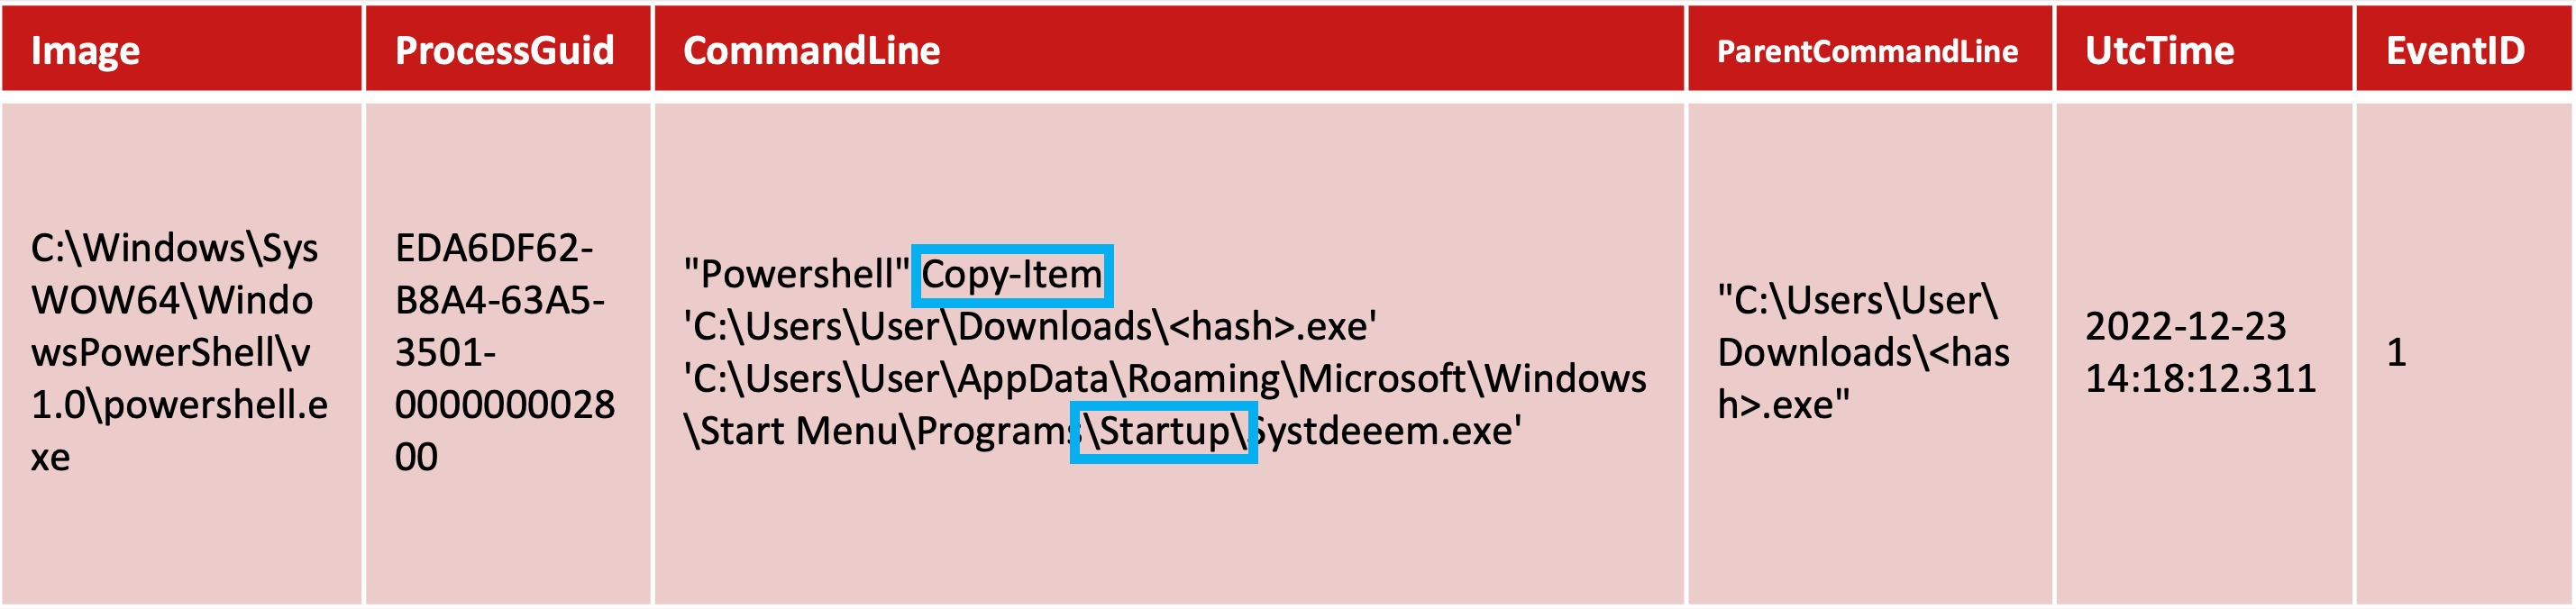

In [ ]:
# Create a filter to show only the malicious logs entries
df[df[...] ...]

<div class="alert alert-danger">
    This cell contains 2 example solutions to this part of the lab activity, but it is currently commented out. It is intended to give you an idea of our example solution, but please do not look at it before the end of the lab activity.
</div>
<!--
<code>
df[df['CommandLine'].str.contains('Copy-Item')]
    
# Or alternatively you can filter on '\Startup\'. This does add irrelevant log entries
df[df['CommandLine'].str.contains(r"\\Startup\\")]
</code>
-->

# Part 2: network traffic, per image

In the second part of this lab activity, we are going to relate network connections with the processes responsible for these connections.

To do this, we first need to import the host data. Note that we have removed significant parts of the data to make the data more manageable for this lab activity.

In [ ]:
df = pd.read_csv('images_ips_ports.csv', index_col=0) # Load the data into a dataframe, which we store in the variable `df`
df.head()                                             # Show the first 5 lines from the data, to give an idea of what it looks like

For this lab activity, we are mainly interested in the ports of the traffic. Before we do that, however, we first show which rows are associated with the malware processes. The Command & Control (C2) server of the malware has the IP address `23.94.236.147`, and we could use that to obtain the rows which are associated with the malware.

In [ ]:
df[df['DestinationIP'] == '23.94.236.147']

However, while this is an effective way to blacklist the C2 server **_currently_** used by the malware, it would be rather straightforward for an attacker to use a different IP address in a future campaign. Similarly, even though the malware currently uses port 6606 for communication with the C2 server, it would be trivial to use a different port in the next version of the malware.

Today, we are not interested in signature-based (or blacklisting) methods. Instead, we are interested in anomaly-based detection methods.

Before we go on, let's see what the traffic for some **_benign_** processes (i.e. processes other than `c:\windows\microsoft.net\framework\v4.0.30319\regsvcs.exe`) looks like.

<div class="alert alert-warning">
    First, we consider what connection data from Microsoft Edge looks like.
</div>

In [ ]:
# Note: we prepend the string with r so we do not need to escape backslashes. Also refer to https://stackoverflow.com/a/4703526
df[(df['Image'] == r'c:\program files (x86)\microsoft\edge\application\msedge.exe') & (df.index.isin([95,221,466,1117,1200]))]
                                                                                                      # Note: we deliberately highlight certain pieces of data here.

<div class="alert alert-warning">
    Next, we consider data from Adobe Acrobat.
</div>

In [ ]:
head_acrobat = df[df['Image'] == r'c:\program files\adobe\acrobat dc\acrobat\acrobat.exe'].head()
# The next line is for later use
indices_head_acrobat = head_acrobat.index
head_acrobat

<div class="alert alert-warning">
    For our final example, let us consider data from Windows Explorer (i.e. <code>explorer.exe</code>), a well-known benign process.
</div>

In [ ]:
head_explorer = df[df['Image'] == r'c:\windows\explorer.exe'].head()
# The next line is for later use
indices_head_explorer = head_explorer.index
head_explorer

<div class="alert alert-success">
    By now, you might be seeing a pattern in the destination ports (i.e. the entries in the column <code>DestinationPort</code>) of the network traffic in the logs. <em>If you do not, that is not a problem.</em>
</div>

For the next step, consider whether there is a way to reduce the amount of entries related to benign activity in the dataframe, by creating and applying a filter _(also known as a boolean mask)_ based on the destination port.

In [ ]:
#### EXERCISE ####
# replace the filtering condition in this cell to reduce the amount of benign activity in the data
df_filtered = df[df['DestinationPort'] ...]
df_filtered.head()

<div class="alert alert-info">
    <strong>Hint:</strong> you may want to have a quick look at <a href="https://en.wikipedia.org/wiki/List_of_TCP_and_UDP_port_numbers#Well-known_ports">the Wikipedia article on TCP and UDP port numbers</a>.
</div>

<div class="alert alert-info">
    <strong>Hint 2:</strong> if you look at that article, focus on the text outside the tables, and not on the text inside the tables.
</div>

<div class="alert alert-danger">
    This cell contains an example solution to this part of the lab activity, but it is currently commented out. It is intended to give you an idea of our example solution, but please do not look at it before the end of the lab activity.
</div>
<!--
<code>
df_filtered = df[df['DestinationPort'] >= 1024]
</code>
-->

At this point, if you want to make sure whether what you did makes sense, feel free to ask us.

Now that we have filtered the data, let us check which log entries from the programs we checked before remain in the filtered data.

In [ ]:
# Microsoft Edge
df_filtered[(df_filtered['Image'] == r'c:\program files (x86)\microsoft\edge\application\msedge.exe') & (df_filtered.index.isin([95,221,466,1117,1200]))]

In [ ]:
# Adobe Acrobat
df_filtered[(df_filtered['Image'] == r'c:\program files\adobe\acrobat dc\acrobat\acrobat.exe') & (df_filtered.index.isin(indices_head_acrobat))]

In [ ]:
# Windows Explorer
df_filtered[(df_filtered['Image'] == r'c:\windows\explorer.exe') & (df_filtered.index.isin(indices_head_explorer))]

<div class="alert alert-success">
    For reference: in our example solution, two of the three programs do not have any log entries listed after applying the filter. If you have doubts on your solution after reading this, feel free to ask us.
</div>

At this point, we are going to give you some time to think: is there some way to filter the remaining data _(based on the destination port of traffic)_ in such a way that only the malware process remains?

To be clear on this: it is not necessary to filter the data for the specific port number used by the malware (i.e. we are not looking for a filter that simply returns all traffic bound for port 6606). Such a method would be more-or-less signature-based, whereas we are looking for an anomaly-based method.

<div class="alert alert-info">
    <strong>Hint 3:</strong> we are looking for a method which would also work to detect different versions of the malware, which were configured to use a different port for communication with the command & control server (e.g. a version which would use port 6607 instead of port 6606, or a version which would use port 7726 instead of port 6606). Think of how this idea can be made more general.
</div>

In [ ]:
#### EXERCISE ####
# try to find a method which obtains the malware process filename from the remaining data, without depending on the specific port number (6606) used by the malware


<div class="alert alert-danger">
    This cell contains an example solution to this part of the lab activity, but it is currently commented out. It is intended to give you an idea of our example solution, but please do not look at it before the end of the lab activity.
</div>
<!--
<code>
for image in df_filtered['Image'].unique():
    unique_destination_ports = df_filtered[df_filtered['Image'] == image]['DestinationPort'].unique()
    print(image, unique_destination_ports)
    if len(unique_destination_ports) == 1:
        display(Markdown("**Process " + image + " shows anomalous behaviour.**"))
</code>
-->